In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import lightgbm as lgb

import shap

import os
import src

from dotenv import load_dotenv

import joblib

In [85]:
pd.options.display.float_format = '{:,.2f}'.format

In [42]:
def clean_df(df):

    FE2_MAX = 20
    FE2_MIN = 0
    CORG_MAX = 2
    CTOT_MAX = 5
    AS_S_MAX = 16
    D_SL_H_MAX = 1868

    df = df.drop(df[df['Fe2+'] > FE2_MAX].index)
    df = df.drop(df[df['Fe2+'] == FE2_MIN].index)
    # df = df.replace({'Fe2+': {0, np.NaN}})

    df = df.drop(df[df['Corg'] > CORG_MAX].index)
    df = df.drop(df[df['Ctot'] > CTOT_MAX].index)
    df = df.drop(df[df['As'] > AS_S_MAX].index)

    df = df.drop(df[df['D_SL_H'] > D_SL_H_MAX].index)

    return df

In [25]:
def get_x_y(df):
    X = df.drop(['Fe2+', 'C_S', 'G_S'], axis=1)
    X = X.reset_index(drop=True)
    y = df['Fe2+']
    y = y.reset_index(drop=True)

    return X, y

In [69]:
lgb_model = joblib.load('..\\models\model_lgb_opt.pkl')

In [67]:
filepath_101 = f'..\\data\\test\\df_test_101_f.zip'

df_101 = pd.read_csv(filepath_101, index_col=0, parse_dates=True)
df_101.shape

(3086, 51)

In [68]:
filepath_102 = f'..\\data\\test\\df_test_102_f.zip'

df_102 = pd.read_csv(filepath_102, index_col=0, parse_dates=True)
df_102.shape

(3094, 51)

In [23]:
df_101.describe().T

,count,mean,std,min,25%,50%,75%,max
QQ_C1,3094.0,21.590324,5.025090,4.574870,17.840423,20.983954,24.800493,37.263360
QQ_C2,3094.0,28.515882,4.417375,3.334077,26.001373,27.734304,31.884820,39.109619
QQ_C3,3094.0,16.872871,2.829988,3.059462,16.160498,17.151688,18.773366,21.344896
QQ_C4,3094.0,5.606486,1.656188,0.932961,4.139319,5.539925,6.703727,9.504075
QQ_C5,3094.0,0.927661,0.970822,0.002889,0.002894,0.997199,1.162077,4.664730
O2_tot,3094.0,5796.302826,969.934950,2075.591343,5148.513869,5399.737232,6999.778395,7565.161905
QQ_tot,3094.0,73.513485,11.918094,11.911352,65.713940,71.606430,83.140546,97.956555
O2_C1,3094.0,2021.356243,348.896746,741.997147,1801.152137,1850.305570,2433.867424,2685.907152
O2_C2,3094.0,2017.657661,352.757066,54.976223,1797.874243,1850.985842,2431.979936,2685.474630
O2_C3,3094.0,1100.364115,194.061774,372.942057,938.136117,1030.081785,1270.755945,1488.535075


In [70]:
df_clean_101 = clean_df(df_101)
X_101, y_101 = get_x_y(df_clean_101)

In [71]:
X_101.shape

(3084, 48)

Метрики качества
RMSE: 0.8692
MAE: 0.3414
R2: 0.2921


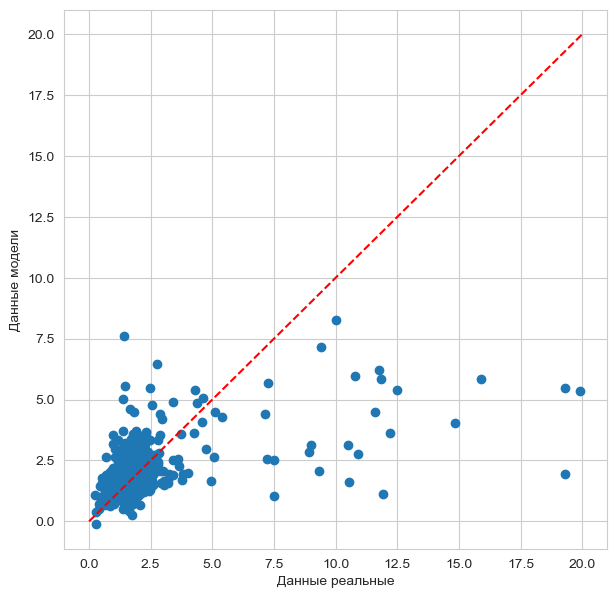

In [72]:
src.lib.model_score(lgb_model, X_101, y_101)

In [112]:
y_mean = y_101.mean()
naive_pred = np.full(y_101.shape, fill_value=y_mean)

In [114]:
mean_absolute_error(y_101, naive_pred)

0.40347971455535586

In [116]:
mean_squared_error(y_101, naive_pred) ** 0.5

1.0330599228727837

In [74]:
pred_101 = lgb_model.predict(X_101)

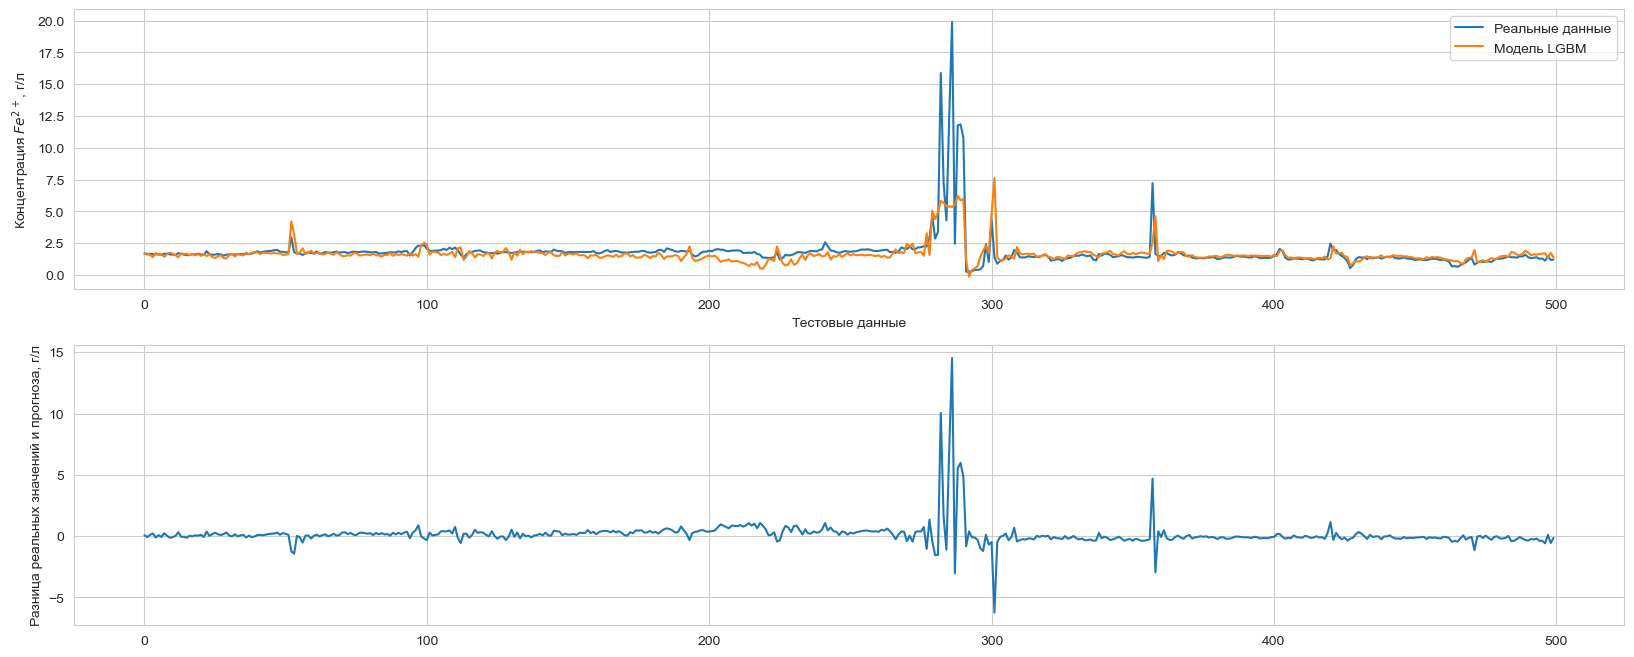

In [99]:
fig, axs = plt.subplots(2, 1, figsize=(20,8))

start = 2000
end = 2500

diff = y_101.values[start:end] - pred_101[start:end]

axs[0].plot(y_101.values[start:end], label='Реальные данные')
axs[0].plot(pred_101[start:end], label='Модель LGBM')

axs[1].plot(diff, label='Модель LGBM')

axs[0].set_ylabel("Концентрация $Fe^{2+}$, г/л")
axs[0].set_xlabel('Тестовые данные')
axs[0].legend()

axs[1].set_ylabel("Разница реальных значений и прогноза, г/л")

plt.show();

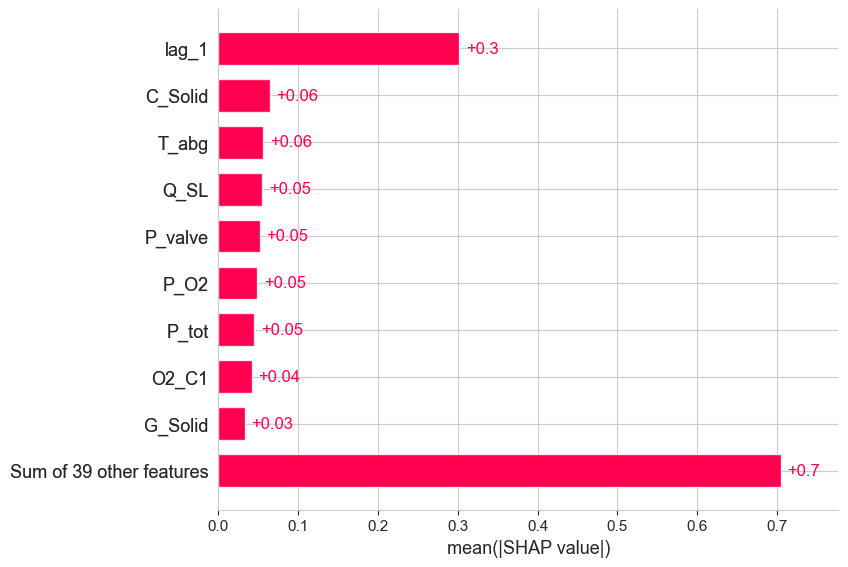

In [77]:
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_101)

shap.plots.bar(shap_values)

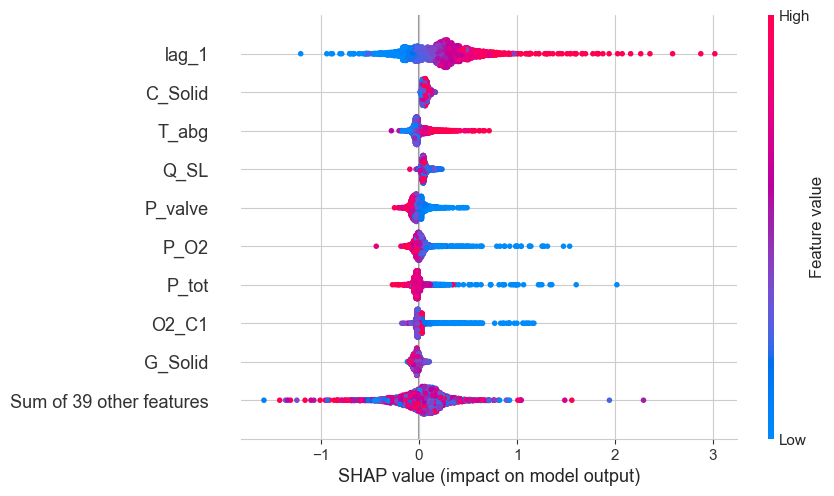

In [78]:
shap.plots.beeswarm(shap_values)

In [79]:
diff = y_101 - pred_101

diff_df = pd.DataFrame(diff)
diff_df = diff_df.assign(real=y_101)
diff_df = diff_df.assign(pred=pred_101)
diff_df.reset_index(inplace=True)

diff_df.columns = ['Data', 'Diff', 'Real', 'Pred']

diff_df.head()

,Data,Diff,Real,Pred
0,0,-0.555149,0.46,1.015149
1,1,-0.283149,0.47,0.753149
2,2,-0.095395,0.72,0.815395
3,3,-0.547412,0.88,1.427412
4,4,-0.096607,1.37,1.466607


In [89]:
diff_df.loc[diff_df['Diff'] > 1].sort_values(by=['Diff'], ascending=False)

,Data,Diff,Real,Pred
798,798,17.34,19.30,1.96
2286,2286,14.53,19.89,5.36
1180,1180,13.82,19.30,5.48
267,267,10.80,14.83,4.03
799,799,10.78,11.90,1.12
2282,2282,10.05,15.89,5.84
351,351,8.90,10.53,1.63
269,269,8.58,12.22,3.64
473,473,8.14,10.90,2.76
472,472,7.38,10.50,3.12


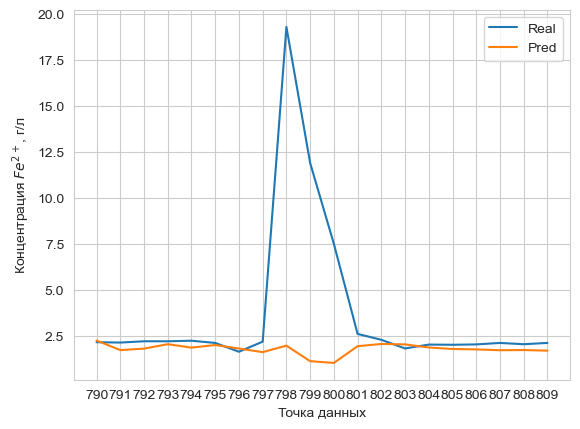

In [100]:
diff_df[['Real', 'Pred']].iloc[790:810].plot(xlabel = "Точка данных", ylabel="Концентрация $Fe^{2+}$, г/л", xticks=np.arange(790, 810, 1));

In [97]:
diff_df[['Real', 'Pred']].iloc[795:805]

,Real,Pred
795,2.11,2.00
796,1.63,1.80
797,2.18,1.61
798,19.30,1.96
799,11.90,1.12
800,7.50,1.02
801,2.60,1.93
802,2.28,2.05
803,1.81,2.03
804,2.02,1.86


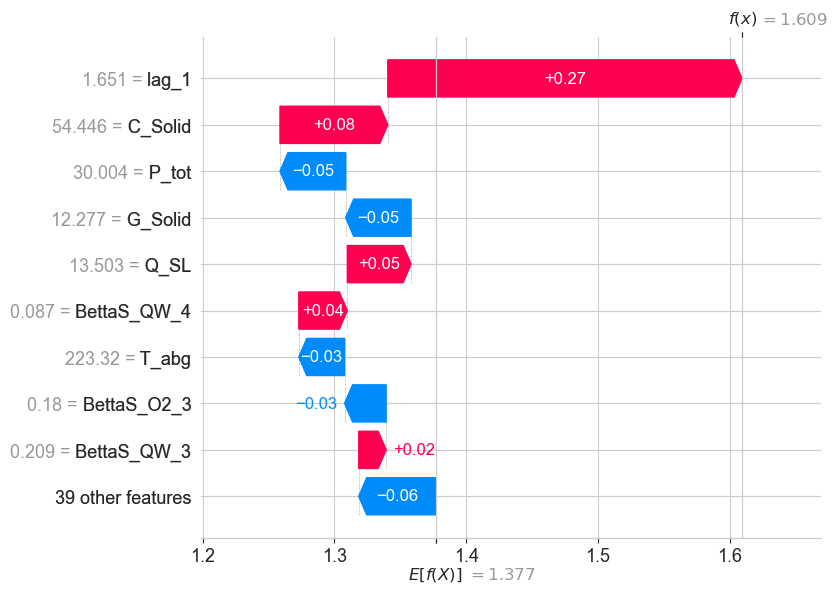

In [91]:
shap.plots.waterfall(shap_values[797])

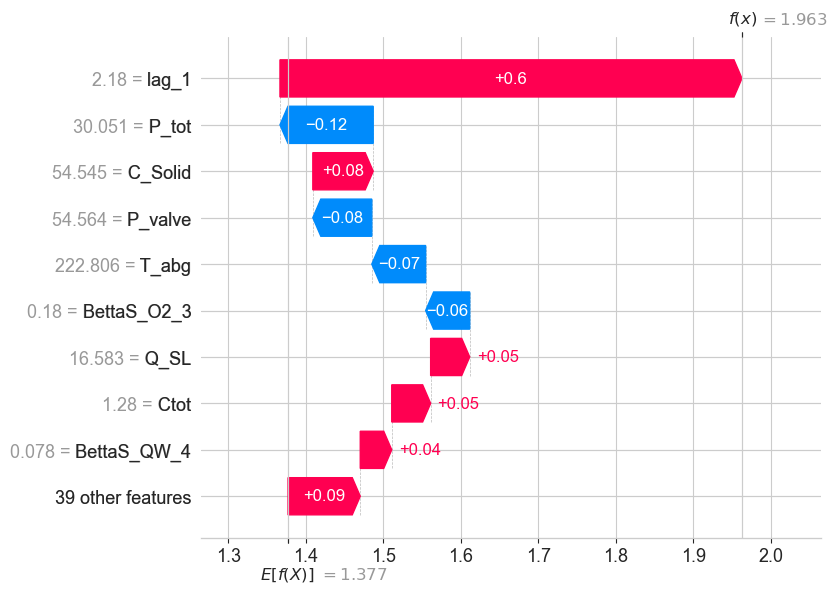

In [93]:
shap.plots.waterfall(shap_values[798])

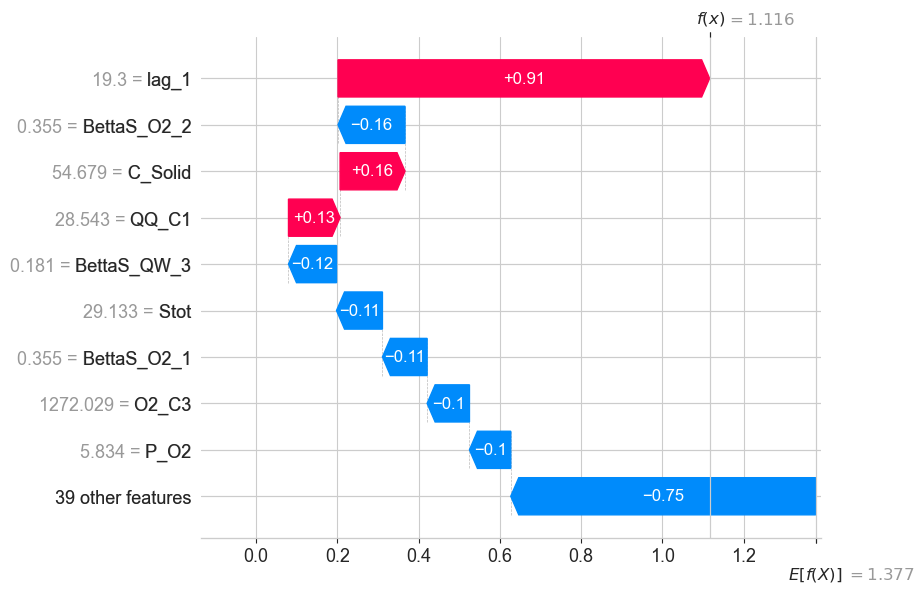

In [94]:
shap.plots.waterfall(shap_values[799])

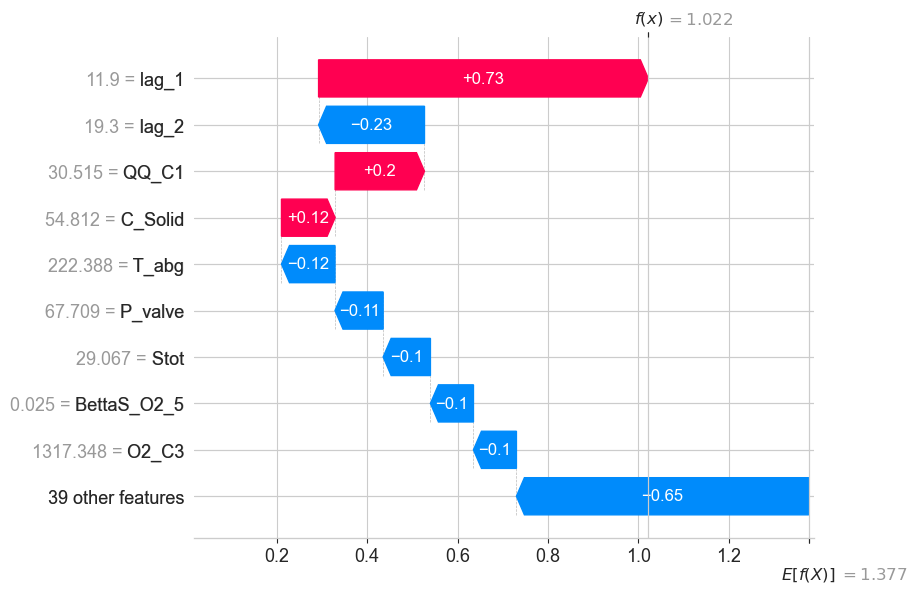

In [98]:
shap.plots.waterfall(shap_values[800])

# AC102

In [101]:
df_clean_102 = clean_df(df_102)
X_102, y_102 = get_x_y(df_clean_102)

Метрики качества
RMSE: 1.0858
MAE: 0.4251
R2: 0.1226


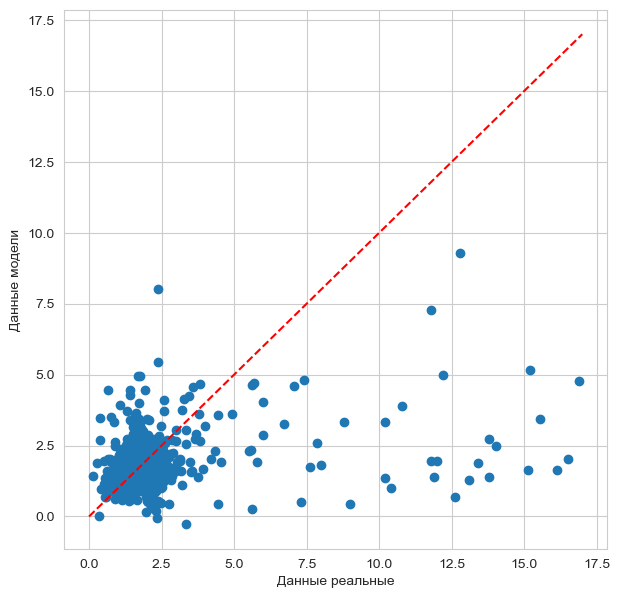

In [102]:
src.lib.model_score(lgb_model, X_102, y_102)

In [103]:
pred_102 = lgb_model.predict(X_102)

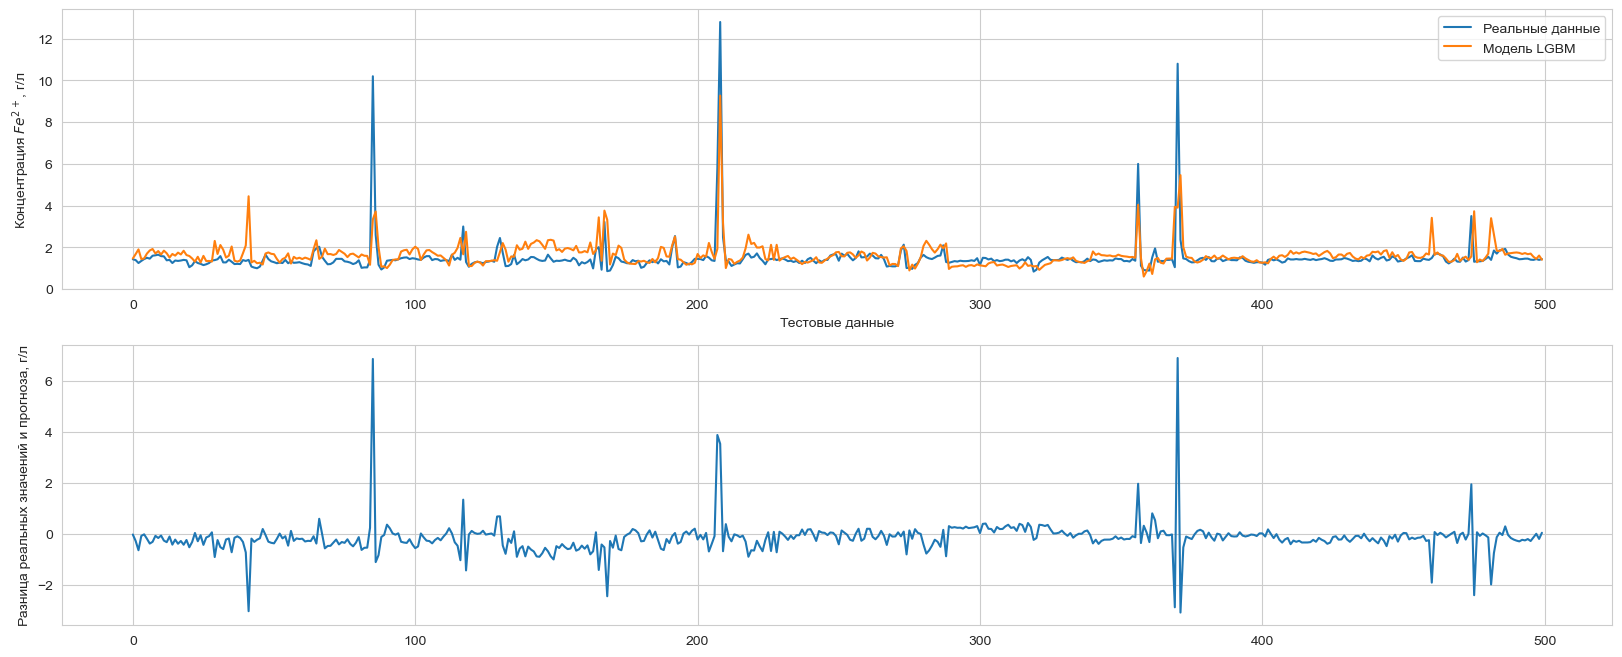

In [107]:
fig, axs = plt.subplots(2, 1, figsize=(20,8))

start = 2500
end = 3000

diff_102 = y_102.values[start:end] - pred_102[start:end]

axs[0].plot(y_102.values[start:end], label='Реальные данные')
axs[0].plot(pred_102[start:end], label='Модель LGBM')

axs[1].plot(diff_102, label='Модель LGBM')

axs[0].set_ylabel("Концентрация $Fe^{2+}$, г/л")
axs[0].set_xlabel('Тестовые данные')
axs[0].legend()

axs[1].set_ylabel("Разница реальных значений и прогноза, г/л")

plt.show();

Линейная модель

In [118]:
linear = joblib.load('..\\models\model_linear.pkl')

The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.



Метрики качества
RMSE: 1.0027
MAE: 0.4406
R2: 0.0579


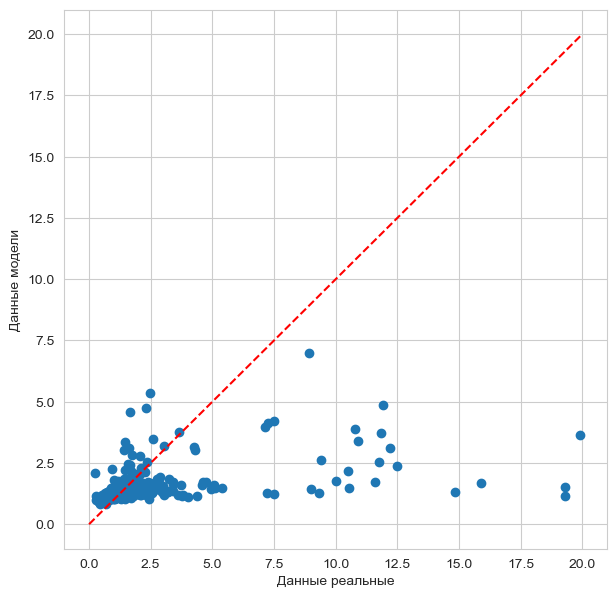

In [120]:
src.lib.model_score(linear, X_101, y_101)